# Тематическое моделирование

In [ ]:
!pip install --quiet -U bigartm pymorphy2[fast] pyLDAvis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Библиотеки

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec

from tqdm.notebook import tqdm
import numpy as np
import  pandas as pd
import seaborn as sns
import pymorphy2
import torch
import scipy
from sklearn.utils import shuffle
import re

import artm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

## Загружаем данные

In [6]:
data = pd.read_csv('drive/MyDrive/DATASETS/MachineLearning'
                   '/topicmodeling/lenta-ru-filtered.csv')

In [7]:
data

,text,tags,len,date
0,С 1 сентября на всей территории России вводитс...,Все,1654,31-08-1999
1,"По сведениям миссии ООН, передаваемым РИА ""Нов...",Все,1086,31-08-1999
2,15 представителей национал-большевистской парт...,Все,1219,31-08-1999
3,Намеченная на сегодняшний день церемония вступ...,Все,3094,31-08-1999
4,"На юге Киргизии, а именно в Баткенском и Чон-А...",Все,1354,31-08-1999
...,...,...,...,...
863280,Популярное место среди туристов в Мурманской о...,Россия,1231,11-09-2020
863281,Рейтинги от международного рейтингового агентс...,NaN,1425,11-09-2020
863282,Российские ученые нашли в Якутии новый подвид ...,События,1299,11-09-2020
863283,Для указания коронавируса как причины смерти ч...,Общество,2061,11-09-2020


In [8]:
data.describe()

,len
count,863285.000000
mean,1341.245505
std,572.066583
min,3.000000
25%,980.000000
50%,1253.000000
75%,1596.000000
max,55387.000000


Видно, что новостные заметки занимают порядка 1.2 кб текста, что является порядка 3/4 страницы А4 печатного текста. Данная длина текста приемлема для анализа, так как не является слишком короткими (как например твиты, порядка 0.2 кб).

Заметим, что в данных присутсвует поле tags (посути это можно рассматривать как топик). Данное поле будет интерестно в последующем анализе.

In [12]:
topics = [x.lower() for x in np.unique(
    np.array(data['tags'].values, dtype=str)).tolist() if x != 'nan']
topics[:10], len(topics)

(['69-я параллель',
  'coцсети',
  'авто',
  'автобизнес',
  'аналитика рынка',
  'английский футбол',
  'белоруссия',
  'бизнес',
  'бокс и мма',
  'вещи'],
 94)

## Предобработка текстов (возможно улучшение)

### Токенизаторы

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')

In [4]:
word_tokenizer = RegexpTokenizer(r'[a-zа-яёЁА-ЯA-Z]+|[^\w\s]|\d+')
sent_tokenizer = lambda sent: nltk.sent_tokenize(sent, language="russian")

### Лематизатор для русского

In [ ]:
nltk.download('stopwords')
# pymorphy2 анализатор
morph = pymorphy2.MorphAnalyzer()
# стоп слова из nltk
stops = nltk.corpus.stopwords.words('russian')

In [6]:
def proccess_text(text):
    text= text.lower()
    sents = sent_tokenizer(text)
    words = list(
        itertools.chain.from_iterable(
            word_tokenizer.tokenize_sents(sents)))
    return [x for x in [morph.normal_forms(word)[0] for word in words ]\
            if x not in stops]

In [2]:
# data_text = data['text']
# for i in tqdm(range(len(data))):
#     data_text.loc[i] = ' '.join(proccess_text(data_text.loc[i]))
# data.to_csv('drive/MyDrive/DATASETS/MachineLearning'
#             '/topicmodeling/lenta-ru-proccess.csv', index=False)

# препроцесинг занимает порядка двух часов (из-за лематизации), поэтому 
# рекомендуется загрузить сразу обработанную версию
data = pd.read_csv(
    'drive/MyDrive/DATASETS/MachineLearning'
    '/topicmodeling/lenta-ru-proccess.csv')

In [3]:
data

,text,tags,len,date
0,1 сентябрь весь территория россия вводиться но...,Все,1654,31-08-1999
1,"сведение миссия оон , передаваемый риа "" новос...",Все,1086,31-08-1999
2,15 представитель национал - большевистский пар...,Все,1219,31-08-1999
3,наметить сегодняшний день церемония вступление...,Все,3094,31-08-1999
4,"юг киргизия , именно баткенский чон - алайском...",Все,1354,31-08-1999
...,...,...,...,...
863280,популярный место среди турист мурманский облас...,Россия,1231,11-09-2020
863281,рейтинг международный рейтинговый агентство s ...,NaN,1425,11-09-2020
863282,российский учёный найти якутия новый подвид ар...,События,1299,11-09-2020
863283,указание коронавирус причина смерть человек не...,Общество,2061,11-09-2020


## LDA

In [4]:
texts = data['text'].values.tolist()
topics = data['tags'].values.tolist()

texts, topics = shuffle(texts, topics)


In [5]:
texts_train = texts[:30000]
texts_test = texts[-10000:]

topics_train = topics[:30000]
topics_test = topics[-10000:]

In [6]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(texts_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [8]:
train_doc_vectors = vectorizer.transform(texts_train)

In [9]:
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(train_doc_vectors)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [10]:
feature_train = lda.transform(train_doc_vectors)

In [13]:
topics_train = np.array(topics_train)

In [14]:
classifier = RandomForestClassifier(n_estimators=10)
classifier.fit(feature_train, topics_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
test_doc_vectors = vectorizer.transform(texts_test)

In [16]:
feature_test = lda.transform(test_doc_vectors)

In [17]:
pred = classifier.predict(feature_test)

In [18]:
topics_test = np.array(topics_test)

In [19]:
print(classification_report(topics_test, pred, zero_division=1))

                      precision    recall  f1-score   support

             Coцсети       0.14      0.11      0.12        47
                 nan       0.12      0.06      0.08       344
                Авто       0.00      0.00      0.00         2
   Английский футбол       0.50      0.14      0.22         7
          Белоруссия       0.00      0.00      0.00        43
              Бизнес       0.11      0.03      0.04       113
          Бокс и ММА       0.06      0.02      0.03        42
                Вещи       0.00      0.00      0.00         3
     Вирусные ролики       0.00      0.00      0.00         5
         Внешний вид       0.14      0.10      0.12        20
                 Все       0.57      0.90      0.70      5207
             Гаджеты       0.00      0.00      0.00        35
               Город       0.00      0.00      0.00        25
        Госэкономика       0.27      0.14      0.19       211
                Дача       0.00      0.00      0.00        18
       

## BigARTM

### Перевод данных в формат данных для bigartm (+ деление на train/valid)

In [16]:
filename_valid = ('drive/MyDrive/DATASETS/MachineLearning'
                  '/topicmodeling/vw_data/texts_valid.vw.txt')
filename_train = ('drive/MyDrive/DATASETS/MachineLearning'
                  '/topicmodeling/vw_data/texts_train.vw.txt')

In [ ]:
counter_train = 0
counter_valid = 0

y_train = []
y_valid = []

reg = re.compile(r'\W+')
with open(filename_valid, 'w') as fout_valid:
    with open(filename_train, 'w') as fout_train:
        for i in tqdm(range(len(data))):
            text = (reg.sub(' ', data.loc[i]['text']).strip()).split()
            label = '_'.join(data.loc[i]['date'].split('-')[1:])


            if len(text) > 100:
                if (i + 1) % 100 == 0:
                    fout_valid.write('doc_{} {} |@month class_{}\n'.format(
                        counter_train, ' '.join(text), label))
                    counter_train += 1
                    y_valid.append(str(data.loc[i]['tags']).lower().strip())
                else:
                    fout_train.write('doc_{} {} |@month class_{}\n'.format(
                        counter_valid, ' '.join(text), label))
                    counter_valid += 1
                    y_train.append(str(data.loc[i]['tags']).lower().strip())                    

In [18]:
with open('drive/MyDrive/DATASETS/MachineLearning'
          '/topicmodeling/vw_data/y_valid.vw.txt', 'w') as f:
    f.write('\n'.join(y_valid))

with open('drive/MyDrive/DATASETS/MachineLearning'
          '/topicmodeling/vw_data/y_train.vw.txt', 'w') as f:
    f.write('\n'.join(y_train))

### Посмотрим на данный формат данных

In [17]:
!head -2 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/vw_data/texts_valid.vw.txt

doc_0 причина смерть меньший мера 34 малазийский ребёнок возраст 5 месяц 7 год стать неизвестный вирус вызывающий прекращение деятельность сердце мозг утверждать учёный проводить свой исследование страна это сегодня утром сообщить радиостанция ввс первоначально предполагаться причина смерть стать давно известный врач сезонный лихорадка однако поздний выясниться сердце мозг ребёнок поразить неизвестный вирус наблюдение пациент госпиталь субить опубликовать исследователь журнал the lancet доказать большинство умерший ребёнок развиться миокардит воспаление мозг вызвать сезонный лихорадка возбудитель болезнь признанный аденовирус назвать учёный agent y правило аденовирус опасный жизнь вызывать нетяжелый заболевание тип известный простуда однако именно agent y обнаружить исследование ткань сердце мозг погибший ребёнок учёный вынудить признать видимо речь идти новый разновидность вирус возникнуть южный азия утверждение bbc вспышка похожий заболевание произойти 1998 год тайвань |@month class_

In [18]:
!wc -l drive/MyDrive/DATASETS/MachineLearning/topicmodeling/vw_data/texts_valid.vw.txt

6604 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/vw_data/texts_valid.vw.txt


In [19]:
!head -2 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/vw_data/texts_train.vw.txt

doc_0 1 сентябрь весь территория россия вводиться новый форма таможенный декларация физический лицо пояснить государственный таможенный комитет гтк форма декларация который одобрить совет руководитель таможенный служба государство участник содружество являться единый территория весь страна снг исключение армения данные итар тасс новый декларация содержаться подробный перечень товар подлежащее обязательный декларирование впервые число включить ядовитый сильно действующий вещество лекарство радиоактивный материал объект флор фауна также высокочастотный радио электронный устройство средство связь частность система радиолокация кабельный телевидение средство мобильный связь частота выше 9 килогерц кроме декларация необходимый приводить подробный сведение ввозить вывозить транспортный средство вид машинs год выпуск объесть двигатель номер двигатель кузов шасси россия новый форма декларация наряду прежний применяться 1 август лишь московский таможенный пункт шереметьево внуково домодедово чк

In [20]:
!wc -l drive/MyDrive/DATASETS/MachineLearning/topicmodeling/vw_data/texts_train.vw.txt

653795 drive/MyDrive/DATASETS/MachineLearning/topicmodeling/vw_data/texts_train.vw.txt


### Создаем батчи

In [10]:
bv_train = artm.BatchVectorizer(
    data_path=filename_train, data_format='vowpal_wabbit', batch_size=10000, 
    target_folder='drive/MyDrive/DATASETS/MachineLearning'
                  '/topicmodeling/vw_batches/batches_train', )

bv_test = artm.BatchVectorizer(
    data_path=filename_valid, data_format='vowpal_wabbit', batch_size=10000, 
    target_folder='drive/MyDrive/DATASETS/MachineLearning'
                  '/topicmodeling/vw_batches/batches_valid')


### Создаем словарь

In [3]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='drive/MyDrive/DATASETS/MachineLearning/topicmodeling/batches_train')

### Создаем модель

#### Загрузка из дампа

In [4]:
# # обучать долго - есть дампы
# model = artm.load_artm_model('./drive/MyDrive/DATASETS/MachineLearning/topicmodeling/model/without_regular/')

# model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary), overwrite=True)

#### Обучаем новую

In [ ]:
model = artm.ARTM(num_topics=200,
                  dictionary=dictionary, 
                  class_ids={'@default_class': 1.0, 
                             '@month': 10.0})

model.scores.add(artm.PerplexityScore(name='perplexity', dictionary=dictionary))
model.scores.add(artm.TopTokensScore(name='top-tokens', num_tokens=10))
model.scores.add(artm.SparsityPhiScore(name='sparsity', class_id='@month'))

In [ ]:
iterator = tqdm(range(10))
for i in iterator:
    model.fit_offline(bv_train, num_collection_passes=1)
    iterator.set_postfix({'perplexity': model.score_tracker['perplexity'].value[-1],  
                          'sparsity': model.score_tracker['sparsity'].value[-1],})

In [ ]:
# model.dump_artm_model('drive/MyDrive/DATASETS/MachineLearning/topicmodeling/model/without_regular')

### Анализ метрик

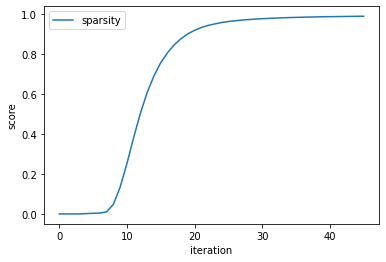

In [24]:
plt.plot(model.score_tracker['sparsity'].value, label = 'sparsity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

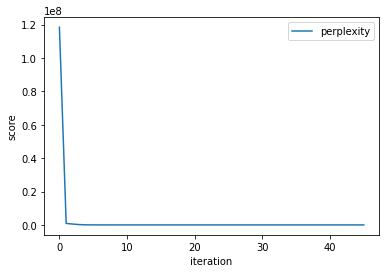

In [25]:
plt.plot(model.score_tracker['perplexity'].value, label = 'perplexity')

plt.legend(loc = 'best')

plt.xlabel('iteration')
plt.ylabel('score')
plt.show()

In [26]:
top_tokens = model.score_tracker['top-tokens'].last_tokens

for topic_name in model.topic_names:
    print(top_tokens[topic_name])

['учёный', 'исследование', 'который', 'исследователь', 'человек', 'анализ', 'вывод', 'клетка', 'журнал', 'это']
['английский', 'перейти', 'переход', 'лондонский', 'англия', 'который', 'челси', 'манчестер', 'арсенал', 'это']
['германия', 'немецкий', 'который', 'берлин', 'фрг', 'меркель', 'канцлер', 'свой', 'ангел', 'австрия']
['создать', 'создание', 'зона', 'который', 'конференция', 'структура', 'объединить', 'новый', 'объединение', 'весь']
['решение', 'принять', 'должный', 'срок', 'договор', 'условие', 'документ', 'отказ', 'подписать', 'отказаться']
['заявление', 'отношение', 'ситуация', 'выразить', 'мид', 'заявить', 'позиция', 'свой', 'подчеркнуть', 'интерес']
['министерство', 'ведомство', 'чиновник', 'внутренний', 'департамент', 'государственный', 'анатолий', 'глава', 'оборона', 'юстиция']
['октябрь', '17', '23', '26', '18', '13', '21', '27', '14', 'это']
['июль', 'культура', 'это', 'который', 'деятель', 'вино', 'сообщать', 'никита', 'также', 'соколов']
['индия', 'индийский', 'пакист

### Вспомним, что есть тэги

In [11]:
X_train_pd = model.transform(bv_train)

In [12]:
X_train_pd

,240000,240001,240002,240003,240004,240005,240006,240007,240008,240009,240010,240011,240012,240013,240014,240015,240016,240017,240018,240019,240020,240021,240022,240023,240024,240025,240026,240027,240028,240029,240030,240031,240032,240033,240034,240035,240036,240037,240038,240039,...,509960,509961,509962,509963,509964,509965,509966,509967,509968,509969,509970,509971,509972,509973,509974,509975,509976,509977,509978,509979,509980,509981,509982,509983,509984,509985,509986,509987,509988,509989,509990,509991,509992,509993,509994,509995,509996,509997,509998,509999
topic_0,7.591373e-07,4.139946e-09,1.050154e-03,4.180786e-07,4.172356e-04,8.844605e-12,2.074991e-10,2.616312e-09,2.698302e-03,1.328421e-07,1.155801e-05,2.243360e-07,1.143587e-06,2.398608e-06,5.536848e-08,6.455931e-07,2.170729e-10,1.036083e-02,3.378920e-06,2.535905e-10,1.796770e-07,6.348900e-09,5.614630e-05,1.314645e-13,6.566562e-12,2.079920e-03,3.609284e-06,2.798780e-09,2.059436e-09,1.736346e-02,1.184854e-02,8.518239e-13,1.719540e-13,2.986309e-09,7.098694e-09,1.399859e-05,2.305126e-09,1.211751e-07,2.454824e-10,1.511967e-07,...,4.644470e-04,1.443934e-07,3.609558e-07,1.054106e-07,8.000304e-07,3.255018e-06,1.421048e-05,9.070399e-11,2.530701e-05,1.464298e-06,1.931113e-06,2.827068e-02,2.931319e-08,1.191693e-03,3.122049e-07,7.025536e-05,5.686167e-03,1.554760e-07,2.689233e-06,2.781892e-08,4.136885e-07,4.884879e-10,8.620657e-06,7.062329e-07,1.336312e-06,1.161858e-05,5.269263e-08,1.763325e-12,1.710462e-06,1.777046e-09,4.760131e-06,1.760061e-07,8.321281e-03,3.384582e-07,4.168352e-04,2.260400e-09,5.606336e-07,1.963711e-10,1.364797e-06,5.022316e-08
topic_1,9.578021e-03,4.273166e-09,3.719441e-07,7.447409e-03,1.159167e-07,1.230532e-10,1.080704e-02,2.006763e-07,1.424901e-09,4.489787e-08,3.217650e-06,1.030882e-06,1.863525e-06,2.010948e-05,5.123760e-08,1.745641e-09,6.070965e-07,1.314054e-06,1.481185e-07,1.081878e-07,3.979017e-07,7.596901e-07,1.569185e-07,5.148415e-09,1.838865e-08,6.238243e-08,1.038682e-08,1.625106e-07,7.655446e-08,3.777072e-09,2.351068e-08,4.492580e-07,1.282557e-07,7.861390e-07,1.327944e-08,6.131005e-03,1.754502e-07,7.978913e-09,1.150097e-05,9.165901e-06,...,9.494073e-06,9.568702e-09,4.968477e-08,8.687201e-08,2.235848e-08,7.104810e-10,1.724642e-07,1.468792e-08,9.094706e-10,5.386634e-08,8.573069e-09,2.562816e-10,2.557031e-09,8.398356e-07,6.843375e-09,3.375748e-07,3.246344e-03,3.486136e-07,3.042515e-02,1.426592e-09,4.609110e-10,5.062384e-03,1.916285e-09,8.609793e-08,3.675144e-10,3.637156e-10,3.694230e-08,3.396507e-05,2.571306e-07,1.459051e-09,5.759832e-10,4.126341e-09,1.536678e-05,1.028565e-08,2.518479e-07,3.897454e-07,5.137344e-09,6.608709e-07,2.421484e-10,1.888744e-09
topic_2,5.984965e-10,2.010423e-08,2.136726e-08,3.294248e-12,4.147962e-12,2.663961e-09,1.378662e-08,1.664855e-12,7.078441e-09,8.766480e-06,2.906054e-11,1.584891e-09,2.497488e-08,2.413110e-10,1.293322e-09,3.144207e-10,9.643389e-03,2.166867e-09,9.895577e-11,1.688926e-09,5.164633e-09,5.194603e-11,5.763142e-09,1.113427e-12,2.227705e-15,1.906263e-10,1.147911e-10,3.707840e-09,2.662379e-12,1.078698e-09,3.740424e-02,3.374536e-11,4.499371e-11,1.970584e-09,1.391211e-09,2.565775e-11,2.487212e-10,6.722619e-09,2.154446e-08,1.028771e-07,...,6.666665e-03,5.224556e-12,7.070555e-11,2.600442e-10,9.196482e-09,8.020370e-09,2.046457e-08,1.442724e-11,3.324964e-15,2.288855e-02,7.137854e-03,4.761020e-11,2.718915e-10,1.344774e-11,6.029883e-10,3.769403e-09,4.185815e-11,2.223382e-09,4.941529e-10,1.093949e-13,1.209211e-11,9.164482e-13,8.655462e-10,2.599718e-10,1.002880e-06,7.762838e-03,3.936537e-10,2.615228e-06,9.828223e-09,8.867010e-15,4.230521e-10,5.074682e-12,1.518351e-10,7.232367e-11,7.161930e-10,2.805428e-07,4.113637e-10,2.943385e-12,8.586354e-03,7.500758e-09
topic_3,2.049694e-09,3.572142e-09,2.122145e-06,6.082659e-13,2.654531e-07,1.360075e-09,5.970147e-10,4.237120e-11,1.346858e-02,6.262915e-05,1.007748e-02,4.226217e-05,3.335494e-06,2.072960e-05,2.373964e-09,2.096300e-02,1.490642e-08,2.653673e-10,8.672852e-03,1.488095e-08,1.419000e-0

In [22]:
with open('drive/MyDrive/DATASETS/MachineLearning'
          '/topicmodeling/vw_data/y_valid.vw.txt') as f:
    y_valid = f.read().split('\n')

with open('drive/MyDrive/DATASETS/MachineLearning'
          '/topicmodeling/vw_data/y_train.vw.txt') as f:
    y_train = f.read().split('\n')

In [ ]:
X_train = []
for i in tqdm(range(len(y_train))):
    X_train.append(X_train_pd[i].values)

In [24]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [28]:
X_train, y_train = shuffle(X_train, y_train)

In [30]:
X_train = X_train[:20000]
y_train = y_train[:20000]

In [31]:
classifier = RandomForestClassifier(n_estimators=10)

In [32]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
X_valid_pd = model.transform(bv_test)

In [ ]:
X_valid = []
for i in tqdm(range(len(y_valid))):
    X_valid.append(X_valid_pd[i].values)

In [35]:
pred = classifier.predict(X_valid)

In [36]:
print(classification_report(y_valid, pred, zero_division=1))

                      precision    recall  f1-score   support

             coцсети       0.12      0.05      0.07        39
                 nan       0.21      0.16      0.18       208
                авто       0.00      1.00      0.00         0
          автобизнес       0.00      0.00      0.00         2
   английский футбол       1.00      0.00      0.00         1
          белоруссия       0.00      0.00      0.00        24
              бизнес       0.06      0.03      0.04        70
          бокс и мма       0.61      0.34      0.44        32
                вещи       0.00      0.00      0.00         5
     вирусные ролики       1.00      0.00      0.00         2
         внешний вид       0.17      0.06      0.09        16
                 все       0.60      0.96      0.74      3356
             гаджеты       1.00      0.00      0.00        24
               город       0.50      0.06      0.10        18
        госэкономика       0.28      0.12      0.17       162
       